In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
"""
Observation:
    Type: Box(2)
    Num    Observation               Min            Max
    0      Car Position              -1.2           0.6
    1      Car Velocity              -0.07          0.07
Actions:
    Type: Discrete(3)
    Num    Action
    0      Accelerate to the Left
    1      Don't accelerate
    2      Accelerate to the Right
    Note: This does not affect the amount of velocity affected by the
    gravitational pull acting on the car.
Reward:
     Reward of 0 is awarded if the agent reached the flag (position = 0.5)
     on top of the mountain.
     Reward of -1 is awarded if the position of the agent is less than 0.5.
Starting State:
     The position of the car is assigned a uniform random value in
     [-0.6 , -0.4].
     The starting velocity of the car is always assigned to 0.
Episode Termination:
     The car position is more than 0.5
"""
env = gym.envs.make("MountainCar-v0")
env.seed(0)

[0]

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
# state = [position, ]
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
print(observation_examples[:10])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
# 400维的特征
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

[[-0.24442555 -0.05624698]
 [-0.7218271   0.01716844]
 [-0.49489498  0.04105051]
 [-0.01571601 -0.02206243]
 [ 0.47386098  0.03225113]
 [ 0.255786   -0.03272937]
 [-0.51612574 -0.00746358]
 [-0.06198232  0.04834948]
 [ 0.03322359  0.0337042 ]
 [-0.92984015 -0.01157901]]


FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        
        #每个action 一个FA
        for _ in range(env.action_space.n):
            #sklearn.linear_model.SGDRegressor 包含了 SGD迭代
            model = SGDRegressor(learning_rate="adaptive")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returnsh
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
#         print(s,a)
        # TODO: Implement this!
        if a != None:
            return self.models[a].predict([ self.featurize_state(s)] )[0]

        else:
            Q = []
            for m in self.models:
                Q.append(m.predict([self.featurize_state(s)])[0])
            
            return Q
                
        
        
#         return 0 if a else np.zeros(env.action_space.n)
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.models[a].partial_fit([self.featurize_state(s)],[y])
        
        return None

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} (Reward of last episode = {})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # TODO: Implement this!
        x = env.reset()
        
        while True:
            a_probs = policy(x)
            a = np.random.choice(np.arange(len(a_probs)), p=a_probs)
            
            x_prime, R, done, _ = env.step(a)
            target = None
#             if done:
#                 target = R 
#             else:
            qs = estimator.predict(x_prime) #Q(x_prime, a)

            max_q = np.max(qs) #max Q(x_prime, a)


            target = R + discount_factor * max_q
            
            estimator.update(x, a, target)
            
            # Update statistics
            stats.episode_rewards[i_episode] += R
            stats.episode_lengths[i_episode] += 1
            
            #done的时候 x_prime
            if done:
                break
                
            x = x_prime
        
    
    return stats

In [7]:
estimator = Estimator()

In [8]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 500, epsilon=0.0)

Episode 500/500 (Reward of last episode = -133.0)

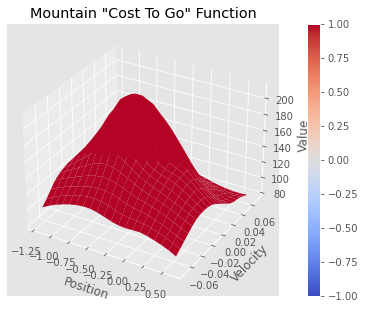

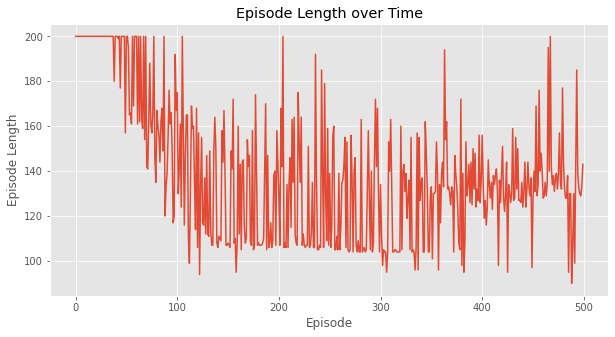

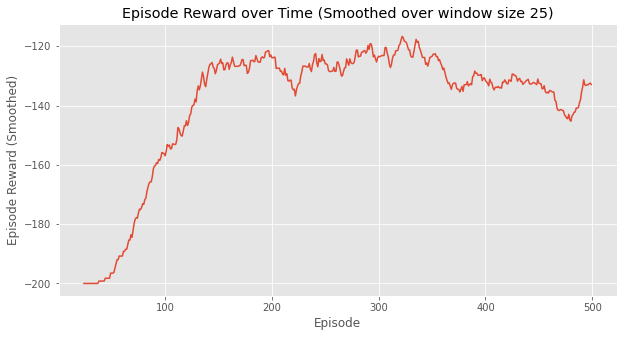

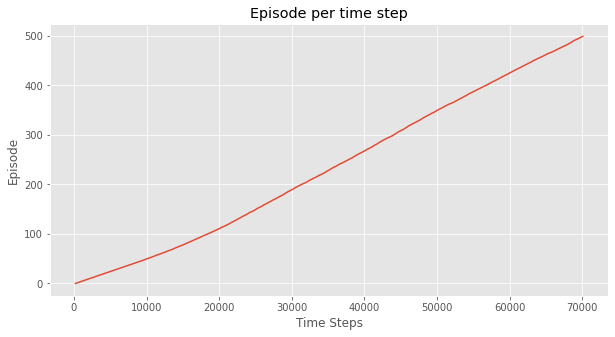

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [10]:
np.max([1,2,3])

3

step  0
step  10
step  20
step  30
step  40
step  50
step  60
step  70
step  80
step  90
step  100
step  110
step  120
done


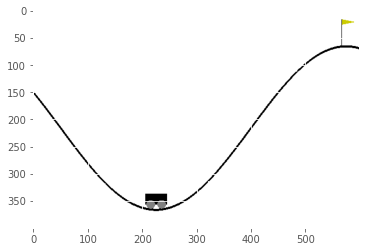

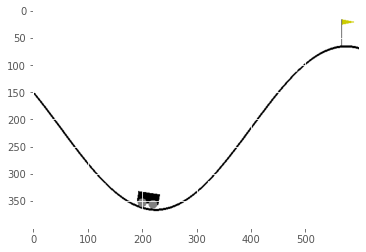

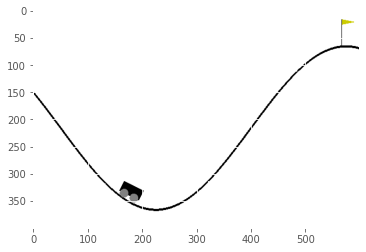

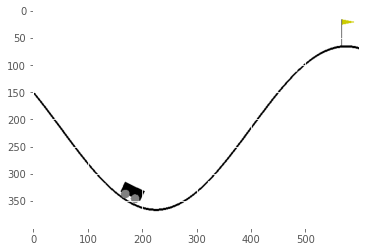

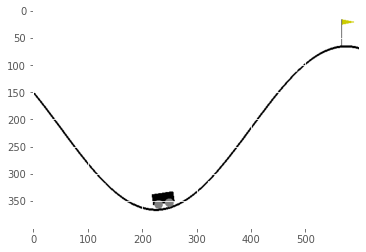

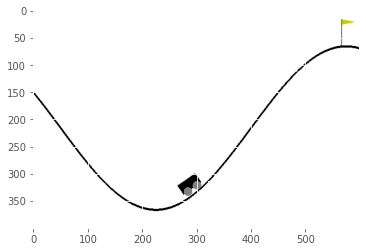

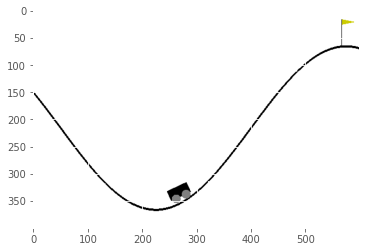

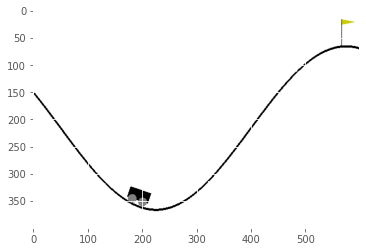

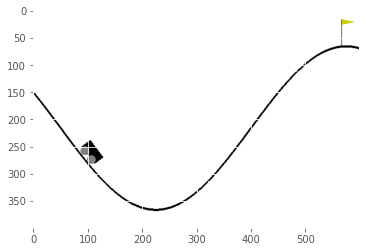

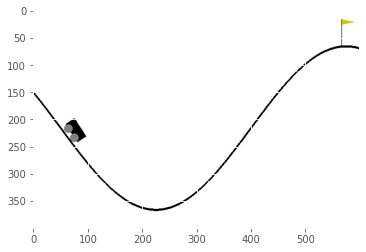

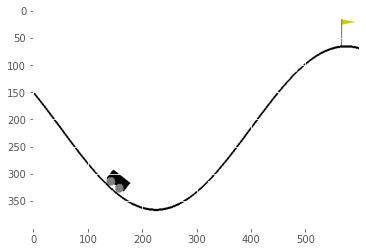

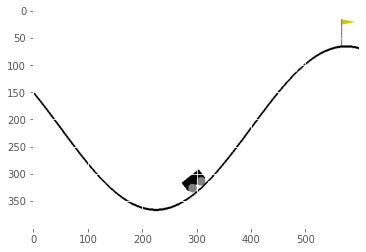

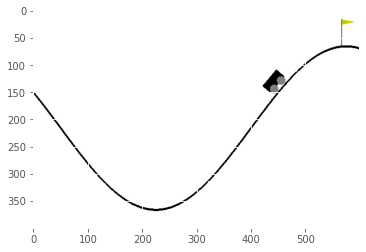

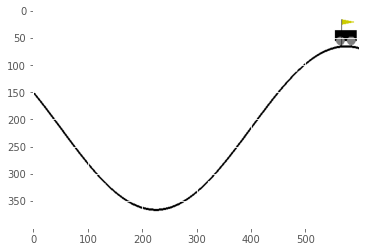

In [18]:
from matplotlib import pyplot as plt

x = env.reset()

i_step = 0
policy = make_epsilon_greedy_policy(
            estimator, 0, env.action_space.n)
while True:
    if i_step % 10 == 0:
        print("step ", i_step)
        plt.figure()
        plt.imshow(env.render(mode='rgb_array'))


    a_probs = policy(x)
    a = np.random.choice(np.arange(len(a_probs)), p=a_probs)

    x_prime, R, done, _ = env.step(a)
    target = None
#             if done:
#                 target = R 
#             else:
    qs = estimator.predict(x_prime) #Q(x_prime, a)

    max_q = np.max(qs) #max Q(x_prime, a)


    target = R + 1.0 * max_q

    estimator.update(x, a, target)


    if done:
        print("done")
        plt.figure()
        plt.imshow(env.render(mode='rgb_array'))
        break

    x = x_prime
    i_step += 1